In [3]:
import pandas as pd
import numpy as np

In [4]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [5]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [6]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [7]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [8]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [9]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [10]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

C:\Users\CHALLA VENKAT RAO\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [12]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [13]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [14]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 40

In [15]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [16]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\CHALLA VENKAT RAO\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [17]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [18]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 40)           8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 40)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 21,206
Trainable params: 21,206
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [20]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 83s 11ms/step - loss: 1.2779 - acc: 0.4758 - val_loss: 1.1361 - val_acc: 0.5348
Epoch 2/30
7352/7352 [==============================] - 79s 11ms/step - loss: 0.9224 - acc: 0.5994 - val_loss: 0.8296 - val_acc: 0.6634
Epoch 3/30
7352/7352 [==============================] - 79s 11ms/step - loss: 0.7865 - acc: 0.6332 - val_loss: 0.7708 - val_acc: 0.6159
Epoch 4/30
7352/7352 [==============================] - 81s 11ms/step - loss: 0.7270 - acc: 0.6549 - val_loss: 0.8228 - val_acc: 0.6043
Epoch 5/30
7352/7352 [==============================] - 80s 11ms/step - loss: 0.7048 - acc: 0.6812 - val_loss: 0.7780 - val_acc: 0.6349
Epoch 6/30
7352/7352 [==============================] - 82s 11ms/step - loss: 0.6563 - acc: 0.7285 - val_loss: 0.6839 - val_acc: 0.7306
Epoch 7/30
7352/7352 [==============================] - 80s 11ms/step - loss: 0.5658 - acc: 0.7681 - val_loss: 0.7339 - val_acc: 0.7306


In [21]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        27        0                   0   
SITTING                  4      409        76        0                   0   
STANDING                 0       77       450        5                   0   
WALKING                  0        0         0      451                   8   
WALKING_DOWNSTAIRS       0        0         0        0                 413   
WALKING_UPSTAIRS         0        0         0        7                   6   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            2  
STANDING                           0  
WALKING                           37  
WALKING_DOWNSTAIRS                 7  
WALKING_UPSTAIRS                 458  


In [22]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 1ms/step


In [23]:
score

[0.612816263583536, 0.9131319986426875]

In [24]:
# model history parameters

history = model.history

train_accuracy = history.history['acc']
train_loss = history.history['loss']
val_accuracy = history.history['val_acc']
val_loss = history.history['val_loss']


epochs = range(1, len(val_accuracy) + 1)

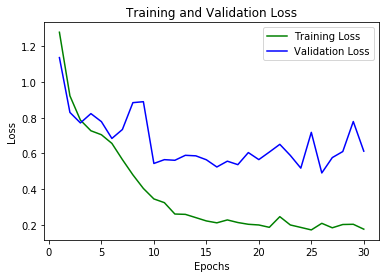

In [27]:
# plot showing  validation accuracy
import matplotlib.pyplot as plt
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

#plt.plot(epochs, val_loss, label='Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

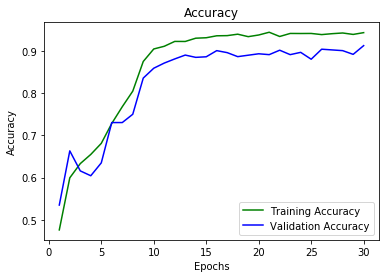

In [28]:
# plot showing  validation accuracy

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
#plt.plot(epochs, val_accuracy, label=' Accuracy')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

## Summary
Model with two LSTM layers ran for 30 epochs got accuracy of 92.02%